In [ ]:
pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/TKC mask"

In [ ]:
%cd /content/drive/MyDrive/TKC mask

/content/drive/MyDrive/TKC mask


In [ ]:
!kaggle datasets download -d vijaykumar1799/face-mask-detection

 96% 214M/222M [00:01<00:00, 120MB/s]
100% 222M/222M [00:02<00:00, 112MB/s]


In [ ]:
!unzip \*.zip &> /dev/null && rm *.zip

In [ ]:
!pip install split-folders
#Split Menjadi 80, 19, 1 %
import splitfolders
splitfolders.ratio('/content/drive/MyDrive/TKC mask/Dataset',
                   output="/content/drive/MyDrive/TKC mask/Fix-Dataset3",
                   seed=42, ratio=(.8 ,0.19,0.01 ), group_prefix=None)

Copying files: 8982 files [01:45, 85.09 files/s]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn import manifold

In [ ]:
class CV_plot_utils:
  # Plot image
  def plot_img(img, range=[0, 255]):
      plt.imshow(img, vmin=range[0], vmax=range[1])
      plt.xlabel("xpixels")
      plt.ylabel("ypixels")
      plt.tight_layout()
      plt.show()
      plt.close()

  # Plots images in 2 rows: top row is query, bottom row is answer
  def plot_query_retrieval(img_query, imgs_retrieval, outFile):
      n_retrieval = len(imgs_retrieval)
      fig = plt.figure(figsize=(2*n_retrieval, 4))
      fig.suptitle("Image Retrieval (k={})".format(n_retrieval), fontsize=25)

      # Plot query image
      ax = plt.subplot(2, n_retrieval, 0 + 1)
      plt.imshow(img_query)
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      for axis in ['top', 'bottom', 'left', 'right']:
          ax.spines[axis].set_linewidth(4)  # increase border thickness
          ax.spines[axis].set_color('black')  # set to black
      ax.set_title("query",  fontsize=14)  # set subplot title

      # Plot retrieval images
      for i, img in enumerate(imgs_retrieval):
          ax = plt.subplot(2, n_retrieval, n_retrieval + i + 1)
          plt.imshow(img)
          ax.get_xaxis().set_visible(False)
          ax.get_yaxis().set_visible(False)
          for axis in ['top', 'bottom', 'left', 'right']:
              ax.spines[axis].set_linewidth(1)  # set border thickness
              ax.spines[axis].set_color('black')  # set to black
          ax.set_title("Rank #%d" % (i+1), fontsize=14)  # set subplot title

      if outFile is None:
          plt.show()
      else:
          plt.savefig(outFile, bbox_inches='tight')
      plt.close()

  # Plot t-SNE of images
  def plot_tsne(X, imgs, outFile):

      def imscatter(x, y, images, ax=None, zoom=1.0):
          if ax is None:
              ax = plt.gca()
          x, y = np.atleast_1d(x, y)
          artists = []
          for x0, y0, img0 in zip(x, y, images):
              im = OffsetImage(img0, zoom=zoom)
              ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=True)
              artists.append(ax.add_artist(ab))
          ax.update_datalim(np.column_stack([x, y]))
          ax.autoscale()
          return artists

      def plot_embedding(X, imgs, title=None):
          x_min, x_max = np.min(X, 0), np.max(X, 0)
          X = (X - x_min) / (x_max - x_min)

          plt.figure()
          ax = plt.subplot(111)
          for i in range(X.shape[0]):
              plt.text(X[i, 0], X[i, 1], ".", fontdict={'weight': 'bold', 'size': 9})
          if hasattr(offsetbox, 'AnnotationBbox'):
              imscatter(X[:,0], X[:,1], imgs, zoom=0.3, ax=ax)

          plt.xticks([]), plt.yticks([])
          if title is not None:
              plt.title(title, fontsize=18)

      tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
      X_tsne = tsne.fit_transform(X)
      plot_embedding(X_tsne, imgs, "t-SNE embeddings")
      if outFile is None:
          plt.show()
      else:
          plt.savefig(outFile, bbox_inches='tight')
      plt.close()

  # Plot image reconstructions
  def plot_reconstructions(imgs, imgs_reconstruct, outFile,
                          range_imgs=[0, 255],
                          range_imgs_reconstruct=[0, 1]):
      # Create plot to save
      assert len(imgs) == len(imgs_reconstruct)
      fig = plt.figure(figsize=(20, 4))
      fig.suptitle("Image Reconstructions", fontsize=35)
      n = min(len(imgs), 10)
      for i in range(n):

          # Plot original image
          ax = plt.subplot(2, n, i + 1)
          plt.imshow(imgs[i],
                    vmin=range_imgs[0],
                    vmax=range_imgs[1])
          ax.get_xaxis().set_visible(False)
          ax.get_yaxis().set_visible(False)

          # Plot reconstructed image
          ax = plt.subplot(2, n, n + i + 1)
          plt.imshow(imgs_reconstruct[i],
                    vmin=range_imgs_reconstruct[0],
                    vmax=range_imgs_reconstruct[1])
          ax.get_xaxis().set_visible(False)
          ax.get_yaxis().set_visible(False)

      if outFile is None:
          plt.show()
      else:
          plt.savefig(outFile, bbox_inches='tight')
      plt.close()

In [ ]:
import os
import skimage.io
from multiprocessing import Pool

In [ ]:
class CV_IO_utils:
  # Read image
  def read_img(filePath):
      return skimage.io.imread(filePath, as_gray=False)

  # Read images with common extensions from a directory
  def read_imgs_dir(dirPath, extensions, parallel=True):
      args = [os.path.join(dirPath, filename)
              for filename in os.listdir(dirPath)
              if any(filename.lower().endswith(ext) for ext in extensions)]
      if parallel:
          pool = Pool()
          imgs = pool.map(CV_IO_utils.read_img, args)
          pool.close()
          pool.join()
      else:
          imgs = [read_img(arg) for arg in args]
      return imgs

  # Save image to file
  def save_img(filePath, img):
      skimage.io.imsave(filePath, img)

In [ ]:
from multiprocessing import Pool
from skimage.transform import resize

# Apply transformations to multiple images
class CV_transform_utils:
    
  def apply_transformer(imgs, transformer, parallel=True):
      if parallel:
          pool = Pool()
          imgs_transform = pool.map(transformer, [img for img in imgs])
          pool.close()
          pool.join()
      else:
          imgs_transform = [transformer(img) for img in imgs]
      return imgs_transform

  # Normalize image data [0, 255] -> [0.0, 1.0]
  def normalize_img(img):
      return img / 255.

  # Resize image
  def resize_img(img, shape_resized):
      img_resized = resize(img, shape_resized,
                          anti_aliasing=True,
                          preserve_range=True)
      assert img_resized.shape == shape_resized
      return img_resized

  # Flatten image
  def flatten_img(img):
      return img.flatten("C")

In [ ]:
import random
import numpy as np

class utils:
    # Get split indices
  def split(fracs, N, seed):
      fracs = [round(frac, 2) for frac in fracs]
      if sum(fracs) != 1.00:
          raise Exception("fracs do not sum to one!")

      # Shuffle ordered indices
      indices = list(range(N))
      random.Random(seed).shuffle(indices)
      indices = np.array(indices, dtype=int)

      # Get numbers per group
      n_fracs = []
      for i in range(len(fracs) - 1):
          n_fracs.append(int(max(fracs[i] * N, 0)))
      n_fracs.append(int(max(N - sum(n_fracs), 0)))

      if sum(n_fracs) != N:
          raise Exception("n_fracs do not sum to N!")

      # Sample indices
      n_selected = 0
      indices_fracs = []
      for n_frac in n_fracs:
          indices_frac = indices[n_selected:n_selected + n_frac]
          indices_fracs.append(indices_frac)
          n_selected += n_frac

      # Check no intersections
      for a, indices_frac_A in enumerate(indices_fracs):
          for b, indices_frac_B in enumerate(indices_fracs):
              if a == b:
                  continue
              if utils.is_intersect(indices_frac_A, indices_frac_B):
                  raise Exception("there are intersections!")

      return indices_fracs

  # Is there intersection?
  def is_intersect(arr1, arr2):
      n_intersect = len(np.intersect1d(arr1, arr2))
      if n_intersect == 0: return False
      else: return True

In [ ]:
import numpy as np
import tensorflow as tf

class AutoEncoder():

    def __init__(self, modelName, info):
        self.modelName = modelName
        self.info = info
        self.autoencoder = None
        self.encoder = None
        self.decoder = None

    # Train
    def fit(self, X, n_epochs=50, batch_size=256):
        indices_fracs = utils.split(fracs=[0.9, 0.1], N=len(X), seed=0)
        X_train, X_valid = X[indices_fracs[0]], X[indices_fracs[1]]
        self.autoencoder.fit(X_train, X_train,
                             epochs = n_epochs,
                             batch_size = batch_size,
                             shuffle = True,
                             validation_data = (X_valid, X_valid))

    # Inference
    def predict(self, X):
        return self.encoder.predict(X)

    # Set neural network architecture
    def set_arch(self):

        shape_img = self.info["shape_img"]
        shape_img_flattened = (np.prod(list(shape_img)),)

        # Set encoder and decoder graphs
        if self.modelName == "simpleAE":
            encode_dim = 128

            input = tf.keras.Input(shape=shape_img_flattened)
            encoded = tf.keras.layers.Dense(encode_dim, activation='relu')(input)

            decoded = tf.keras.layers.Dense(shape_img_flattened[0], activation='sigmoid')(encoded)

        elif self.modelName == "convAE":
            n_hidden_1, n_hidden_2, n_hidden_3 = 16, 8, 8
            convkernel = (3, 3)  # convolution kernel
            poolkernel = (2, 2)  # pooling kernel

            input = tf.keras.layers.Input(shape=shape_img)
            x = tf.keras.layers.Conv2D(n_hidden_1, convkernel, activation='relu', padding='same')(input)
            x = tf.keras.layers.MaxPooling2D(poolkernel, padding='same')(x)
            x = tf.keras.layers.Conv2D(n_hidden_2, convkernel, activation='relu', padding='same')(x)
            x = tf.keras.layers.MaxPooling2D(poolkernel, padding='same')(x)
            x = tf.keras.layers.Conv2D(n_hidden_3, convkernel, activation='relu', padding='same')(x)
            encoded = tf.keras.layers.MaxPooling2D(poolkernel, padding='same')(x)

            x = tf.keras.layers.Conv2D(n_hidden_3, convkernel, activation='relu', padding='same')(encoded)
            x = tf.keras.layers.UpSampling2D(poolkernel)(x)
            x = tf.keras.layers.Conv2D(n_hidden_2, convkernel, activation='relu', padding='same')(x)
            x = tf.keras.layers.UpSampling2D(poolkernel)(x)
            x = tf.keras.layers.Conv2D(n_hidden_1, convkernel, activation='relu', padding='same')(x)
            x = tf.keras.layers.UpSampling2D(poolkernel)(x)
            decoded = tf.keras.layers.Conv2D(shape_img[2], convkernel, activation='sigmoid', padding='same')(x)

        else:
            raise Exception("Invalid model name given!")

        # Create autoencoder model
        autoencoder = tf.keras.Model(input, decoded)
        input_autoencoder_shape = autoencoder.layers[0].input_shape[1:]
        output_autoencoder_shape = autoencoder.layers[-1].output_shape[1:]

        # Create encoder model
        encoder = tf.keras.Model(input, encoded)  # set encoder
        input_encoder_shape = encoder.layers[0].input_shape[1:]
        output_encoder_shape = encoder.layers[-1].output_shape[1:]

        # Create decoder model
        decoded_input = tf.keras.Input(shape=output_encoder_shape)
        if self.modelName == 'simpleAE':
            decoded_output = autoencoder.layers[-1](decoded_input)  # single layer
        elif self.modelName == 'convAE':
            decoded_output = autoencoder.layers[-7](decoded_input)  # Conv2D
            decoded_output = autoencoder.layers[-6](decoded_output)  # UpSampling2D
            decoded_output = autoencoder.layers[-5](decoded_output)  # Conv2D
            decoded_output = autoencoder.layers[-4](decoded_output)  # UpSampling2D
            decoded_output = autoencoder.layers[-3](decoded_output)  # Conv2D
            decoded_output = autoencoder.layers[-2](decoded_output)  # UpSampling2D
            decoded_output = autoencoder.layers[-1](decoded_output)  # Conv2D
        else:
            raise Exception("Invalid model name given!")
        decoder = tf.keras.Model(decoded_input, decoded_output)
        decoder_input_shape = decoder.layers[0].input_shape[1:]
        decoder_output_shape = decoder.layers[-1].output_shape[1:]

        # Generate summaries
        print("\nautoencoder.summary():")
        print(autoencoder.summary())
        print("\nencoder.summary():")
        print(encoder.summary())
        print("\ndecoder.summary():")
        print(decoder.summary())

        # Assign models
        self.autoencoder = autoencoder
        self.encoder = encoder
        self.decoder = decoder

    # Compile
    def compile(self, loss="categorical_crossentropy", optimizer="adam"):
        self.autoencoder.compile(optimizer=optimizer, loss=loss)

    # Load model architecture and weights
    def load_models(self, loss="categorical_crossentropy", optimizer="adam"):
        print("Loading models...")
        self.autoencoder = tf.keras.models.load_model(self.info["autoencoderFile"])
        self.encoder = tf.keras.models.load_model(self.info["encoderFile"])
        self.decoder = tf.keras.models.load_model(self.info["decoderFile"])
        self.autoencoder.compile(optimizer=optimizer, loss=loss)
        self.encoder.compile(optimizer=optimizer, loss=loss)
        self.decoder.compile(optimizer=optimizer, loss=loss)

    # Save model architecture and weights to file
    def save_models(self):
        print("Saving models...")
        self.autoencoder.save(self.info["autoencoderFile"])
        self.encoder.save(self.info["encoderFile"])
        self.decoder.save(self.info["decoderFile"])

In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.neighbors import NearestNeighbors

# Run mode: (autoencoder -> simpleAE, convAE) or (transfer learning -> vgg19)
modelName = "vgg19"  # try: "simpleAE", "convAE", "vgg19"
trainModel = True
parallel = True  # use multicore processing

# Make paths
dataTrainDir = "/content/drive/MyDrive/TKC mask/Fix-Dataset3/train"
dataTestDir = "/content/drive/MyDrive/TKC mask/Fix-Dataset3/test"
outDir = "/content/drive/MyDrive/TKC mask/Fix-Dataset3/output"
if not os.path.exists(outDir):
    os.makedirs(outDir)

# Read images
extensions = [".jpg", ".jpeg",".png"]
print("Reading train images from '{}'...".format(dataTrainDir))
imgs_train = CV_IO_utils.read_imgs_dir(dataTrainDir, extensions, parallel=parallel)
print("Reading test images from '{}'...".format(dataTestDir))
imgs_test = CV_IO_utils.read_imgs_dir(dataTestDir, extensions, parallel=parallel)
shape_img = imgs_train[0].shape
print("Image shape = {}".format(shape_img))

# Build models
if modelName in ["simpleAE", "convAE"]:

    # Set up autoencoder
    info = {
        "shape_img": shape_img,
        "autoencoderFile": os.path.join(outDir, "{}_autoecoder.h5".format(modelName)),
        "encoderFile": os.path.join(outDir, "{}_encoder.h5".format(modelName)),
        "decoderFile": os.path.join(outDir, "{}_decoder.h5".format(modelName)),
    }
    model = AutoEncoder(modelName, info)
    model.set_arch()

    if modelName == "simpleAE":
        shape_img_resize = shape_img
        input_shape_model = (model.encoder.input.shape[1],)
        output_shape_model = (model.encoder.output.shape[1],)
        n_epochs = 300
    elif modelName == "convAE":
        shape_img_resize = shape_img
        input_shape_model = tuple([int(x) for x in model.encoder.input.shape[1:]])
        output_shape_model = tuple([int(x) for x in model.encoder.output.shape[1:]])
        n_epochs = 500
    else:
        raise Exception("Invalid modelName!")

elif modelName in ["vgg19"]:

    # Load pre-trained VGG19 model + higher level layers
    print("Loading VGG19 pre-trained model...")
    model = tf.keras.applications.VGG19(weights='imagenet', include_top=False,
                                        input_shape=shape_img)
    model.summary()

    shape_img_resize = tuple([int(x) for x in model.input.shape[1:]])
    input_shape_model = tuple([int(x) for x in model.input.shape[1:]])
    output_shape_model = tuple([int(x) for x in model.output.shape[1:]])
    n_epochs = None

else:
    raise Exception("Invalid modelName!")

# Print some model info
print("input_shape_model = {}".format(input_shape_model))
print("output_shape_model = {}".format(output_shape_model))

# Apply transformations to all images
class ImageTransformer(object):

    def __init__(self, shape_resize):
        self.shape_resize = shape_resize

    def __call__(self, img):
        img_transformed = CV_transform_utils.resize_img(img, self.shape_resize)
        img_transformed = CV_transform_utils.normalize_img(img_transformed)
        return img_transformed

transformer = ImageTransformer(shape_img_resize)
print("Applying image transformer to training images...")
imgs_train_transformed = CV_transform_utils.apply_transformer(imgs_train, transformer, parallel=parallel)
print("Applying image transformer to test images...")
imgs_test_transformed = CV_transform_utils.apply_transformer(imgs_test, transformer, parallel=parallel)

# Convert images to numpy array
X_train = np.array(imgs_train_transformed).reshape((-1,) + input_shape_model)
X_test = np.array(imgs_test_transformed).reshape((-1,) + input_shape_model)
print(" -> X_train.shape = {}".format(X_train.shape))
print(" -> X_test.shape = {}".format(X_test.shape))

# Train (if necessary)
if modelName in ["simpleAE", "convAE"]:
    if trainModel:
        model.compile(loss="categorical_crossentropy", optimizer="adam")
        model.fit(X_train, n_epochs=n_epochs, batch_size=256)
        model.save_models()
    else:
        model.load_models(loss="categorical_crossentropy", optimizer="adam")

# Create embeddings using model
print("Inferencing embeddings using pre-trained model...")
E_train = model.predict(X_train)
E_train_flatten = E_train.reshape((-1, np.prod(output_shape_model)))
E_test = model.predict(X_test)
E_test_flatten = E_test.reshape((-1, np.prod(output_shape_model)))
print(" -> E_train.shape = {}".format(E_train.shape))
print(" -> E_test.shape = {}".format(E_test.shape))
print(" -> E_train_flatten.shape = {}".format(E_train_flatten.shape))
print(" -> E_test_flatten.shape = {}".format(E_test_flatten.shape))

# Make reconstruction visualizations
if modelName in ["simpleAE", "convAE"]:
    print("Visualizing database image reconstructions...")
    imgs_train_reconstruct = model.decoder.predict(E_train)
    if modelName == "simpleAE":
        imgs_train_reconstruct = imgs_train_reconstruct.reshape((-1,) + shape_img_resize)
    CV_plot_utils.plot_reconstructions(imgs_train, imgs_train_reconstruct,
                         os.path.join(outDir, "{}_reconstruct.png".format(modelName)),
                         range_imgs=[0, 255],
                         range_imgs_reconstruct=[0, 1])

# Fit kNN model on training images
print("Fitting k-nearest-neighbour model on training images...")
knn = NearestNeighbors(n_neighbors=5, metric="cosine")
knn.fit(E_train_flatten)

# Perform image retrieval on test images
print("Performing image retrieval on test images...")
for i, emb_flatten in enumerate(E_test_flatten):
    _, indices = knn.kneighbors([emb_flatten]) # find k nearest train neighbours
    img_query = imgs_test[i] # query image
    imgs_retrieval = [imgs_train[idx] for idx in indices.flatten()] # retrieval images
    outFile = os.path.join(outDir, "{}_retrieval_{}.png".format(modelName, i))
    CV_plot_utils.plot_query_retrieval(img_query, imgs_retrieval, outFile)

# Plot t-SNE visualization
print("Visualizing t-SNE on training images...")
outFile = os.path.join(outDir, "{}_tsne.png".format(modelName))
CV_plot_utils.plot_tsne(E_train_flatten, imgs_train, outFile)

Reading train images from '/content/drive/MyDrive/TKC mask/Fix-Dataset3/train'...
Reading test images from '/content/drive/MyDrive/TKC mask/Fix-Dataset3/test'...
Image shape = (128, 128, 3)
Loading VGG19 pre-trained model...
80150528/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None,

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


contoh hasil output :

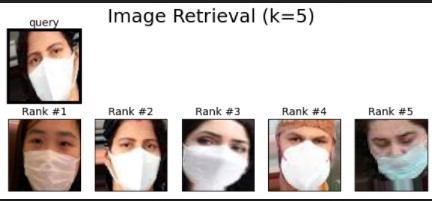